# Analyses of fingerprints

In [18]:
prefix = '/home/ines/repositories/'
prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [19]:
""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# --Machine learning and statistics

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
import umap
from sklearn import mixture
import pickle
from scipy.stats import mode
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.spatial import distance_matrix, distance

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
# from data_processing import save_and_log
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
# from clustering_functions import calculate_entropy
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from plotting_functions import create_grouped_gradient_palette
from one.api import ONE
one = ONE(mode='remote')

In [20]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
filename = str(data_path + 'all_sequences_09-29-2025')
all_sequences = pd.read_parquet(filename)
# filename = str(data_path + 'trial_clusters_5')
# trial_clusters_df = pd.read_parquet(filename)
data_path = prefix + 'representation_learning_variability/paper-individuality/fig4_clustering/'
# cluster_df = pd.read_parquet(data_path+'cluster_per_session')
# cluster_df = pd.read_parquet(data_path+'6_cluster_per_session_11-20-2025')
# cluster_df = pd.read_parquet(data_path+'6_cluster_per_mice_repeated_measures')
cluster_df = pd.read_parquet(data_path+'5_mouse_cluster_coef')
# cluster_df = pd.read_parquet(data_path+'5_cluster_per_mouse_trial')
trial_modes = pd.read_parquet(data_path+'9_cluster_per_trial')


# cluster_df = pd.read_parquet(data_path+'dominant_mouse_cluster')
# cluster_df = cluster_df[['mouse_name', 'dominant_cluster']].drop_duplicates()
# cluster_df = cluster_df.rename(columns={'dominant_cluster': "mouse_cluster"})


In [21]:
identifiable_mapping = {'000': 0.0,
        '100': 1.0,
        '200': 2.0,
        '300': 3.0,
        '400': 4.0,
        '500': 5.0,
        '600': 6.0,
        '700': 7.0,
        
        '010': 8.0,
        '110': 9.0,
        '210': 10.0,
        '310': 11.0,
        '410': 12.0,
        '510': 13.0,
        '610': 14.0,
        '710': 15.0,

        '001': 16.0,
        '101': 17.0,
        '201': 18.0,
        '301': 19.0, 
        '401': 20.0, 
        '501': 21.0, 
        '601': 22.0, 
        '701': 23.0, 

        '011': 24.0,
        '111': 25.0,
        '211': 26.0,
        '311': 27.0,
        '411': 28.0,
        '511': 29.0,
        '611': 30.0,
        '711': 31.0,
        'nan': np.nan
        }

inverted_mapping = {v: k for k, v in identifiable_mapping.items()}
inverted_func = np.vectorize(inverted_mapping.get)
identifiable_func = np.vectorize(identifiable_mapping.get)
    
from matplotlib.colors import ListedColormap, to_rgb, to_hex

def create_grouped_gradient_palette(n_groups=8, shades_per_group=4, base_palette='Set1'):
    # Pick n_groups distinct colors from base palette
    base_colors = sns.color_palette(base_palette, n_colors=n_groups)
    
    # Function to generate shades for a given color
    def generate_shades(color, n_shades):
        color_rgb = np.array(to_rgb(color))
        # Create shades by interpolating towards white (lighter) or black (darker)
        factors = np.linspace(0.4, 1.0, n_shades)  # You can adjust range for more/less contrast
        return [to_hex(color_rgb * factor + (1 - factor)) for factor in factors]
    
    # Build full palette
    full_palette = []
    for color in base_colors:
        shades = generate_shades(color, shades_per_group)
        full_palette.extend(shades)
    
    return ListedColormap(full_palette)

    palette_16 = create_grouped_gradient_palette(n_groups=8, shades_per_group=4, base_palette='Set2')


In [43]:
identifiable_mapping = {'000': 0.0,
        '100': 4.0,
        '200': 8.0,
        '300': 12.0,
        '400': 16.0,
        '500': 20.0,
        '600': 24.0,
        '700': 28.0,
        
        '010': 1.0,
        '110': 5.0,
        '210': 9.0,
        '310': 13.0,
        '410': 17.0,
        '510': 21.0,
        '610': 25.0,
        '710': 29.0,

        '001': 2.0,
        '101': 6.0,
        '201': 10.0,
        '301': 14.0, 
        '401': 18.0, 
        '501': 22.0, 
        '601': 26.0, 
        '701': 30.0, 

        '011': 3.0,
        '111': 7.0,
        '211': 11.0,
        '311': 15.0,
        '411': 19.0,
        '511': 23.0,
        '611': 27.0,
        '711': 31.0,
        'nan': np.nan
        }

# inverted_mapping = {v: k for k, v in identifiable_mapping.items()}
# inverted_func = np.vectorize(inverted_mapping.get)
identifiable_func = np.vectorize(identifiable_mapping.get)

In [44]:
palette_16 = create_grouped_gradient_palette(n_groups=8, shades_per_group=4, base_palette='Set2')

In [24]:
all_sequences['trial_id'] = all_sequences['sample'].str.split().str[1:2].str.join('').astype(float)
all_sequences['session'] = all_sequences['sample'].str.split().str[0:1].str.join('').astype(str)

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_18347/1770735490.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


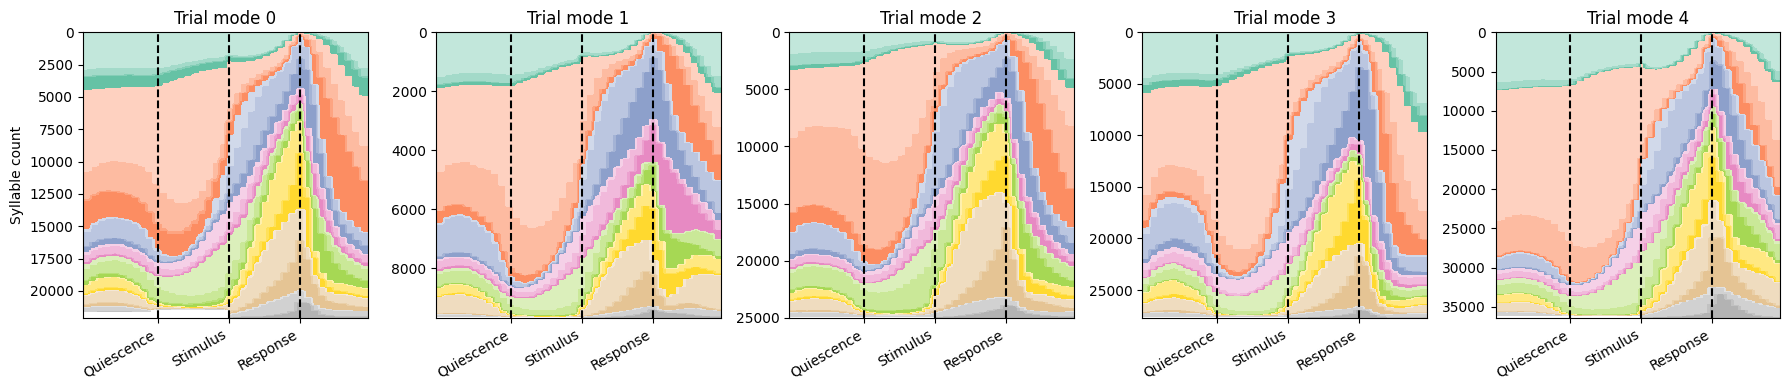

In [25]:
fig, axs = plt.subplots(1, 5, sharex=True, sharey=False, figsize=(18, 4))

epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']
use_sequences = all_sequences.merge(cluster_df[['mouse_name', 'mouse_cluster']], on='mouse_name')
# use_sequences = all_sequences.merge(trial_modes[['sample', 'trial_cluster']], on='sample')
# for m, mat in enumerate(range(len(trial_modes['trial_cluster'].unique()))):
for m, mat in enumerate(range(len(cluster_df['mouse_cluster'].unique()))):

    mouse_data = use_sequences.loc[use_sequences['mouse_cluster']==mat]
    bound = int(np.shape(mouse_data)[0]/4)
    mouse_seq = np.ones((bound, 40)) * np.nan
    all_epochs = []
    for e, epoch in enumerate(epoch_to_analyse):
        epoch_data = np.vstack(mouse_data.loc[mouse_data['broader_label']==epoch, 'binned_sequence'].values)[:bound, :]
        epoch_data = inverted_func(epoch_data)
        # epoch_data = rename_func(epoch_data)
        epoch_data = identifiable_func(epoch_data)
        mouse_seq[:np.shape(epoch_data)[0], 10*e:10*e+10] = epoch_data[:np.shape(epoch_data)[0], :]
        # if e == 0:
        #     all_epochs = epoch_data[:bound-10, :]
        # else:
        #     all_epochs = np.concatenate([all_epochs, epoch_data[:bound-10, :]], axis=1)
    # sorted = all_epochs[np.argsort([ordered_dict[row[0]] for row in all_epochs])]
    axs[m].imshow(np.sort(mouse_seq, axis=0), aspect='auto', cmap=palette_16, interpolation=None, alpha=1)
    axs[m].axvline(x=10, color='k', linestyle='--')
    axs[m].axvline(x=20, color='k', linestyle='--')
    axs[m].axvline(x=30, color='k', linestyle='--')
    axs[0].set_ylabel('Syllable count')
    axs[m].set_xlabel('')
    axs[m].set_title('Trial mode '+str(mat))
    axs[m].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    plt.tight_layout()
    # axs[m].set_yticks('')
    # plt.show()

In [83]:
use_sequences = all_sequences.copy()

use_sequences.mouse_name.unique()

array(['ZFM-02372', 'SWC_054', 'PL033', 'CSH_ZAD_026', 'NR_0027',
       'ZFM-01936', 'SWC_043', 'ibl_witten_29', 'NYU-47', 'DY_020',
       'ibl_witten_32', 'SWC_058', 'UCLA037', 'UCLA017', 'UCLA034',
       'CSH_ZAD_019', 'UCLA048', 'SWC_060', 'NYU-65', 'SWC_052',
       'NR_0020', 'CSH_ZAD_029', 'PL015', 'PL017', 'ZFM-02370', 'NYU-48',
       'ibl_witten_27', 'ZFM-04308', 'NR_0019', 'ibl_witten_26', 'NYU-40',
       'PL024', 'UCLA044', 'DY_016', 'UCLA006', 'SWC_061', 'PL034',
       'NR_0021', 'PL030', 'UCLA011', 'NYU-30', 'UCLA049', 'ZFM-01937',
       'NYU-39', 'UCLA033', 'UCLA052', 'NYU-45', 'NYU-21', 'SWC_053',
       'ZFM-01935', 'DY_018', 'PL031', 'PL016', 'NYU-46', 'SWC_039',
       'ZFM-02373', 'UCLA012', 'ibl_witten_18', 'UCLA014', 'ZFM-02369',
       'UCLA035', 'ZFM-02368', 'ibl_witten_20', 'UCLA036', 'UCLA030',
       'NR_0017', 'ibl_witten_25', 'SWC_066', 'UCLA005', 'SWC_065'],
      dtype=object)

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_18347/1612349153.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


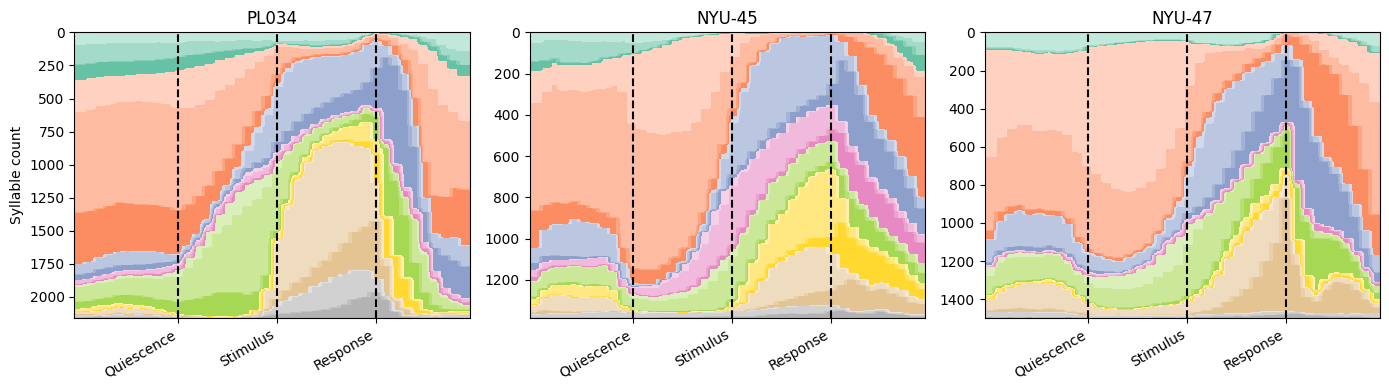

In [56]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=False, figsize=(14, 4))

epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']
use_sequences = all_sequences.copy()
# use_sequences = all_sequences.merge(trial_modes[['sample', 'trial_cluster']], on='sample')
# for m, mat in enumerate(range(len(trial_modes['trial_cluster'].unique()))):
for m, mat in enumerate(['PL034', 'NYU-45','NYU-47']):
# for m, mat in enumerate(['PL034', 'NYU-48', 'UCLA034', 'NYU-45', 'PL033', 'CSH_ZAD_019']):
# for m, mat in enumerate(['PL034', 'UCLA034', 'PL033']):

    mouse_data = use_sequences.loc[use_sequences['mouse_name']==mat]
    bound = int(np.shape(mouse_data)[0]/4)
    mouse_seq = np.ones((bound, 40)) * np.nan
    all_epochs = []
    for e, epoch in enumerate(epoch_to_analyse):
        epoch_data = np.vstack(mouse_data.loc[mouse_data['broader_label']==epoch, 'binned_sequence'].values)[:bound, :]
        epoch_data = inverted_func(epoch_data)
        # epoch_data = rename_func(epoch_data)
        epoch_data = identifiable_func(epoch_data)
        mouse_seq[:np.shape(epoch_data)[0], 10*e:10*e+10] = epoch_data[:np.shape(epoch_data)[0], :]
        # if e == 0:
        #     all_epochs = epoch_data[:bound-10, :]
        # else:
        #     all_epochs = np.concatenate([all_epochs, epoch_data[:bound-10, :]], axis=1)
    # sorted = all_epochs[np.argsort([ordered_dict[row[0]] for row in all_epochs])]
    axs[m].imshow(np.sort(mouse_seq, axis=0), aspect='auto', cmap=palette_16, interpolation=None, alpha=1)
    axs[m].axvline(x=10, color='k', linestyle='--')
    axs[m].axvline(x=20, color='k', linestyle='--')
    axs[m].axvline(x=30, color='k', linestyle='--')
    axs[0].set_ylabel('Syllable count')
    axs[m].set_xlabel('')
    axs[m].set_title(mat)
    axs[m].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    plt.tight_layout()
    # axs[m].set_yticks('')
    # plt.show()

In [57]:
def expand_from_trial_type(df):
    
    df['feedback'] = df['trial_type'].str.split().str[:1].str.join('')
    df['choice'] = df['trial_type'].str.split().str[3:4].str.join('')
    df['block'] = df['trial_type'].str.split().str[2:3].str.join('')
    df['contrast'] = df['trial_type'].str.split().str[1:2].str.join('')
    df['side'] = df['choice'].copy()
    df.loc[(df['feedback']=='correct') & (df['choice']=='right'), 'side'] = 'left'
    df.loc[(df['feedback']=='correct') & (df['choice']=='left'), 'side'] = 'right'
    df['session'] = df['sample'].str.split().str[:1].str.join('')
    df['trial_id'] = df['sample'].str.split().str[1:2].str.join('')
    df['contrast'] = df['contrast'].astype(float)
    df['block'] = df['block'].astype(float)
    df['choice'] = df['trial_type'].str.split().str[3:4].str.join('')
    df.loc[df['choice']=='left', 'choice'] = 0
    df.loc[df['choice']=='right', 'choice'] = 1
    df.loc[df['feedback']=='correct', 'feedback'] = 1
    df.loc[df['feedback']=='incorrect', 'feedback'] = 0
    
    return df

In [58]:

def group_by_var_interest(session_syllables, var_interest, use_states):

    session_syllables = session_syllables.groupby(['mouse_name', 'mouse_cluster', var_interest])[np.arange(0, np.shape(final_matrix)[1], 1)].mean().reset_index()
    
    timesteps = 40
    reshaped_probs = pd.DataFrame()
    clusters = session_syllables['mouse_cluster'].copy()
    v_int = session_syllables[var_interest].copy()

    for i, interest in enumerate(np.unique(v_int)):
        for c, cluster in enumerate(np.unique(clusters)):
            reshaped_probs_cluster = pd.DataFrame(columns=['syllable', 'timestep', 'cluster', 'prob', var_interest], index=range(use_states * timesteps))
            indices = np.where((session_syllables['mouse_cluster']==cluster) & (session_syllables[var_interest]==interest))[0]
            syllable_prob = np.array(session_syllables[session_syllables.keys()[4:]])[indices, :].mean(axis=0)

            for t in range(timesteps):
                reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = ['000', '100', '200', '300', '400', '500', '600', '700', '010', '110',
                            '210', '310', '410', '510', '610', '710', '001', '101', '201', '301', '401', '501', '601', '701', '011',
                            '111', '211', '311', '411', '511',  '611',  '711']
                # reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = ['000', '100', '200', '300', '400','010', '110',
                #         '210', '310', '410', '001', '101', '201', '301', '401',  '011',
                #         '111', '211', '311', '411']
                reshaped_probs_cluster['timestep'][t*use_states:(t+1)*use_states] = t
                reshaped_probs_cluster['prob'][t*use_states:(t+1)*use_states] = syllable_prob[t*use_states:(t+1)*use_states]
                reshaped_probs_cluster['cluster'][t*use_states:(t+1)*use_states] = cluster
                reshaped_probs_cluster[var_interest][t*use_states:(t+1)*use_states] = interest
            # Save
            reshaped_probs = pd.concat([reshaped_probs, reshaped_probs_cluster])
            
    return reshaped_probs

def group_by_cluster(session_syllables, use_states):

    session_syllables = session_syllables.groupby(['mouse_name', 'mouse_cluster'])[np.arange(0, np.shape(final_matrix)[1], 1)].mean().reset_index()
    
    timesteps = 40
    reshaped_probs = pd.DataFrame()
    clusters = session_syllables['mouse_cluster'].copy()

    for c, cluster in enumerate(np.unique(clusters)):
        reshaped_probs_cluster = pd.DataFrame(columns=['syllable', 'timestep', 'cluster', 'prob'], index=range(use_states * timesteps))
        indices = np.where((session_syllables['mouse_cluster']==cluster))[0]
        syllable_prob = np.array(session_syllables[session_syllables.keys()[2:]])[indices, :].mean(axis=0)

        for t in range(timesteps):
            reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = ['000', '100', '200', '300', '400', '500', '600', '700', '010', '110',
                        '210', '310', '410', '510', '610', '710', '001', '101', '201', '301', '401', '501', '601', '701', '011',
                        '111', '211', '311', '411', '511',  '611',  '711']
            # reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] =  ['000', '100', '200', '300', '400','010', '110',
            #             '210', '310', '410', '001', '101', '201', '301', '401',  '011',
            #             '111', '211', '311', '411']
            reshaped_probs_cluster['timestep'][t*use_states:(t+1)*use_states] = t
            reshaped_probs_cluster['prob'][t*use_states:(t+1)*use_states] = syllable_prob[t*use_states:(t+1)*use_states]
            reshaped_probs_cluster['cluster'][t*use_states:(t+1)*use_states] = cluster
        # Save
        reshaped_probs = pd.concat([reshaped_probs, reshaped_probs_cluster])
            
    return reshaped_probs

In [59]:
complete_df = expand_from_trial_type(all_sequences)
complete_df = complete_df.merge(cluster_df[['mouse_name', 'mouse_cluster']], on=['mouse_name'])
# complete_df = complete_df.merge(trial_clusters_df[['mouse_name', 'session', 'trial_id', 'trial_cluster']], on=['mouse_name', 'session', 'trial_id'])

## Get sequences per trial

In [60]:
var_interest = 'block'
var_interest = ''
if len(var_interest) > 0:
    pivoted_df = complete_df.pivot(index=['sample', 'trial_type', 'mouse_name', var_interest], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
else:
    pivoted_df = complete_df.pivot(index=['sample', 'trial_type', 'mouse_name'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
pivoted_df = pivoted_df.merge(cluster_df[['mouse_name', 'mouse_cluster']], on=['mouse_name'])

In [61]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

sequences_choice = np.vstack(pivoted_df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
# use_sequences = replace_func(use_sequences)

use_states = int(max(np.unique(use_sequences)))+1
timesteps = np.shape(use_sequences)[1]
binarized = np.zeros((np.shape(use_sequences)[0], timesteps*use_states))

for t in range(timesteps):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(use_states))
    encoded_arr = label_binarizer.transform(use_sequences[:, t])
    binarized[:, t*use_states:(t+1)*use_states] = encoded_arr

final_matrix = binarized.copy()

In [62]:

session_syllables = pd.DataFrame(final_matrix)
session_syllables['mouse_cluster'] = pivoted_df['mouse_cluster'].copy()
session_syllables['mouse_name'] = pivoted_df['mouse_name'].copy()
use_states = len(np.unique(use_sequences))

if len(var_interest) > 0:
    session_syllables[var_interest] = pivoted_df[var_interest].copy()
    reshaped_probs = group_by_var_interest(session_syllables, var_interest, use_states)
else:
    reshaped_probs = group_by_cluster(session_syllables, use_states)
clusters = cluster_df['mouse_cluster']

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_18347/2854669525.py:46: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = ['000', '100', '200', '300', '400', '500', '

In [63]:
order = ['000', '010', '001', '011', '100', '110', '101', '111', '200', '210', '201', '211',
         '300', '310', '301', '311', '400', '410',  '401', '411',
         '500', '510', '501', '511', '600', '610', '601', '611',
         '700', '710', '701', '711']
labels = ['VL00', 'VL10', 'VL01', 'VL11', 'Low00', 'Low10',  'Low01', 'Low11',
         'Lowish00', 'Lowish10', 'Lowish01', 'Lowish11', 
         'LL-00', 'LL-10', 'LL-01', 'LL-11', 'LR-00', 'LR-10', 'LR-01', 'LR-11', 
         'HL-00', 'HL-10', 'HL-01', 'HL-11', 'HR-00', 'HR-10', 'HR-01', 'HR-11', 
         'H-00', 'H-10', 'H-01', 'H-11']


# order = ['000', '010', '001', '011', 
#          '100', '110', '101', '111', '200', '210', '201', '211',
#          '300', '310', '301', '311', '400', '410',  '401', '411']
# labels = ['Low00', 'Low10',  'Low01', 'Low11',
#          'Lowish00', 'Lowish10', 'Lowish01', 'Lowish11', 
#          'L-00', 'L-10', 'L-01', 'L-11', 'R-00', 'R-10', 'R-01', 'R-11',
#          'H-00', 'H-10', 'H-01', 'H-11']

rename_labels = dict(zip(np.array(order), np.array(labels)))
rename_func = np.vectorize(rename_labels.get)

In [64]:
palette_30 = create_grouped_gradient_palette(n_groups=8, shades_per_group=4, base_palette='Set2')
palette_30_list = [palette_30(i) for i in range(palette_30.N)]  # Extract colors properly

palette_16 = create_grouped_gradient_palette(n_groups=2, shades_per_group=4, base_palette='Set1')
palette_16_list = [palette_16(i) for i in range(palette_16.N)]  # Extract colors properly
state_to_color = dict(zip(order, palette_16_list))

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_18347/3925042737.py:13: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_y_axes().join(row_axes[0], ax)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_g

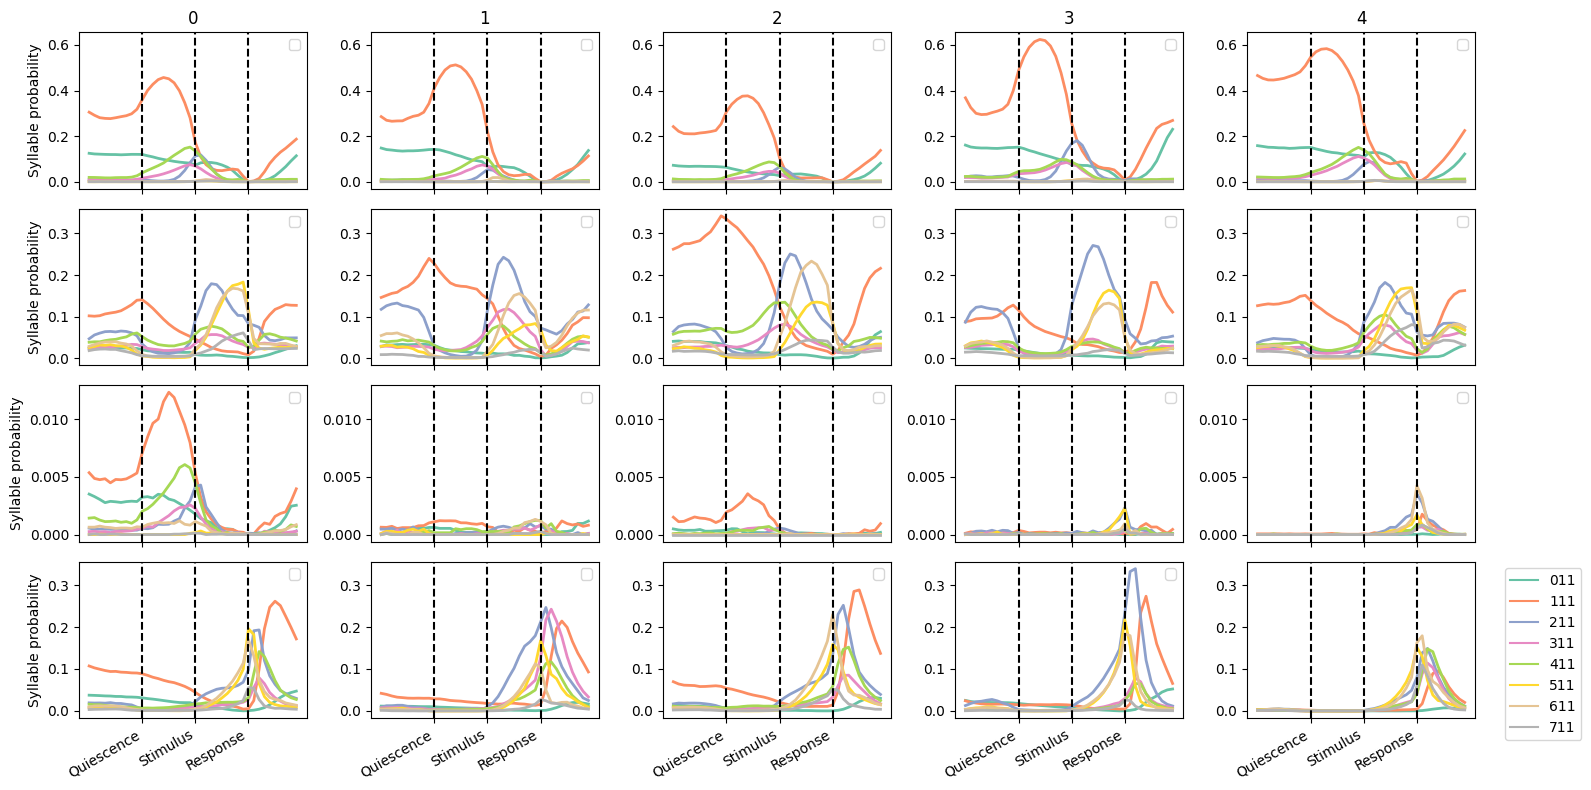

In [65]:
syllable_labels = [['000', '100', '200', '300', '400', '500', '600', '700'],
                   ['010', '110', '210', '310', '410', '510', '610', '710'],
                   ['001', '101', '201', '301', '401', '501', '601', '701'],
                   ['011', '111', '211', '311', '411', '511', '611', '711']]
palette_7 = create_grouped_gradient_palette(n_groups=8, shades_per_group=1, base_palette='Set2')
palette_7_list = [palette_7(i) for i in range(palette_30.N)]  # Extract colors properly

fig, axs = plt.subplots(4, 5, sharex=True, sharey=False, figsize=(16, 8))
for r in range(4):
    # axes[r, :] are all axes in row r
    row_axes = axs[r, :]
    for ax in row_axes[1:]:
        ax.get_shared_y_axes().join(row_axes[0], ax)

for i in range(4):
    # fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(16, 2))
    for c, cluster in enumerate(np.unique(clusters)):
        use_data = reshaped_probs.loc[reshaped_probs['cluster']==cluster]
        # use_data['syllable'] = rename_func(use_data['syllable'])
        use_syllables = syllable_labels[i]
        use_data = use_data.loc[use_data['syllable'].isin(use_syllables)]
        sns.lineplot(x='timestep', y='prob', hue='syllable', data=use_data, 
                    ax=axs[i, c], palette='Set2',  linewidth=2)  #  legend=labels[c]  style=var_interest,

        axs[i, c].axvline(x=10, color='k', linestyle='--')
        axs[i, c].axvline(x=20, color='k', linestyle='--')
        axs[i, c].axvline(x=30, color='k', linestyle='--')
        axs[i, c].set_ylabel('')
        axs[i, 0].set_ylabel('Syllable probability')
        axs[i, c].set_xlabel('')
        # axs[c].set_ylim([0, 0.85])
        axs[i, c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
        axs[i, c].legend('')
        axs[0, c].set_title(cluster)
axs[i, c].legend(loc='upper left', bbox_to_anchor=(1.1, 1))
plt.tight_layout()

In [72]:
order = ['000', '010', '001', '011', '100', '110', '101', '111', '200', '210', '201', '211',
         '300', '310', '301', '311', '400', '410',  '401', '411',
         '500', '510', '501', '511', '600', '610', '601', '611',
         '700', '710', '701', '711']
labels = ['0', '0', '0', '0', 
          '1', '1', '1', '1',
          '2', '2', '2', '2',
          '3', '3', '3', '3',
          '4', '4', '4', '4',
          '5', '5', '5', '5',
          '6', '6', '6', '6',
          '7', '7', '7', '7'
          ]


rename_labels = dict(zip(np.array(order), np.array(labels)))
rename_func = np.vectorize(rename_labels.get)

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_26183/2420400624.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['syllable'] = rename_func(use_data['syllable'])
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anacond

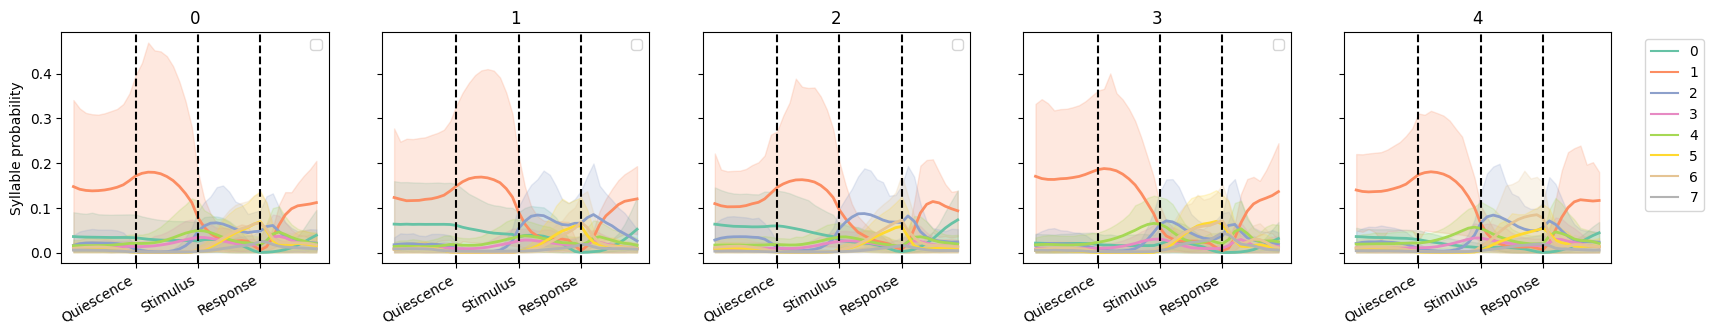

In [118]:

syllable_labels = ['000', '100', '200', '300', '400', '500', '600', '700',
                   '010', '110', '210', '310', '410', '510', '610', '710',
                   '001', '101', '201', '301', '401', '501', '601', '701',
                   '011', '111', '211', '311', '411', '511', '611', '711']

palette_7 = create_grouped_gradient_palette(n_groups=8, shades_per_group=1, base_palette='Set2')
palette_7_list = [palette_7(i) for i in range(palette_7.N)]  # Extract colors properly


fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(20, 3))

for c, cluster in enumerate(np.unique(clusters)):
    use_data = reshaped_probs.loc[reshaped_probs['cluster']==cluster]
    use_data['syllable'] = rename_func(use_data['syllable'])
    use_data = use_data.copy()
    sns.lineplot(x='timestep', y='prob', hue='syllable', data=use_data, 
                ax=axs[c], palette='Set2',  linewidth=2)  #  legend=labels[c]  style=var_interest,

    axs[c].axvline(x=10, color='k', linestyle='--')
    axs[c].axvline(x=20, color='k', linestyle='--')
    axs[c].axvline(x=30, color='k', linestyle='--')
    axs[c].set_ylabel('Syllable probability')
    axs[c].set_xlabel('')
    # axs[c].set_ylim([0, 0.85])
    axs[c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    axs[c].legend('')
    axs[c].set_title(cluster)
axs[c].legend(loc='upper left', bbox_to_anchor=(1.1, 1))

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_18347/2854669525.py:46: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = ['000', '100', '200', '300', '400', '500', '

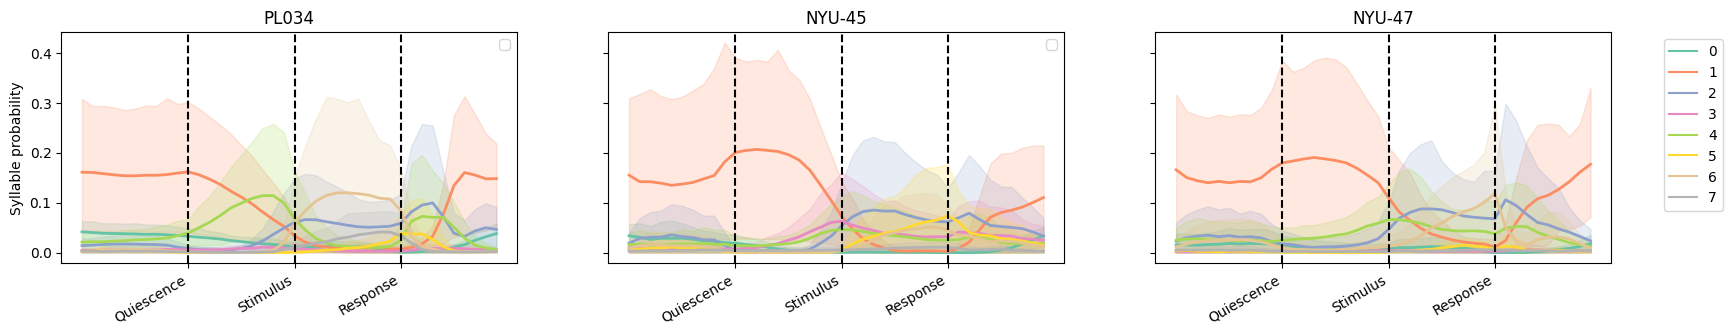

In [73]:


syllable_labels = ['000', '100', '200', '300', '400', '500', '600', '700',
                   '010', '110', '210', '310', '410', '510', '610', '710',
                   '001', '101', '201', '301', '401', '501', '601', '701',
                   '011', '111', '211', '311', '411', '511', '611', '711']

palette_7 = create_grouped_gradient_palette(n_groups=8, shades_per_group=1, base_palette='Set2')
palette_7_list = [palette_7(i) for i in range(palette_7.N)]  # Extract colors properly


fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(20, 3))


for c, mat in enumerate(['PL034', 'NYU-45','NYU-47']):
    reshaped_probs = group_by_cluster(session_syllables.loc[session_syllables['mouse_name']==mat], use_states)

    use_data = reshaped_probs.copy()
    use_data['syllable'] = rename_func(use_data['syllable'])
    use_data = use_data.copy()
    sns.lineplot(x='timestep', y='prob', hue='syllable', data=use_data, 
                ax=axs[c], palette='Set2',  linewidth=2)  #  legend=labels[c]  style=var_interest,

    axs[c].axvline(x=10, color='k', linestyle='--')
    axs[c].axvline(x=20, color='k', linestyle='--')
    axs[c].axvline(x=30, color='k', linestyle='--')
    axs[c].set_ylabel('Syllable probability')
    axs[c].set_xlabel('')
    # axs[c].set_ylim([0, 0.85])
    axs[c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    axs[c].legend('')
    axs[c].set_title(mat)
axs[c].legend(loc='upper left', bbox_to_anchor=(1.1, 1))

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_26183/1766390690.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['syllable'] = rename_func(use_data['syllable'])
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anacond

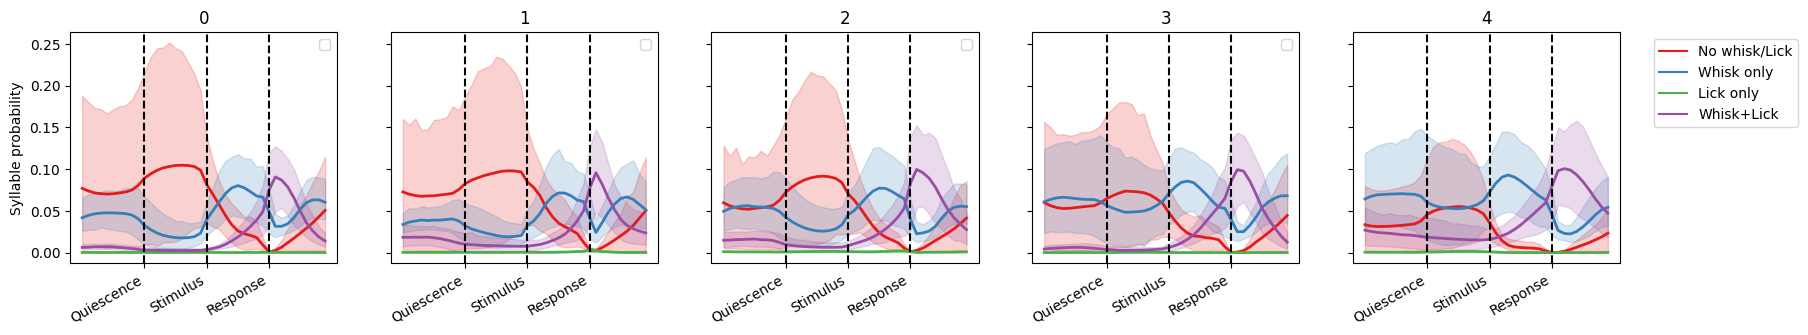

In [120]:

syllable_labels = ['000', '100', '200', '300', '400', '500', '600', '700',
                   '010', '110', '210', '310', '410', '510', '610', '710',
                   '001', '101', '201', '301', '401', '501', '601', '701',
                   '011', '111', '211', '311', '411', '511', '611', '711']

palette_7 = create_grouped_gradient_palette(n_groups=8, shades_per_group=1, base_palette='Set1')
palette_7_list = [palette_7(i) for i in range(palette_7.N)]  # Extract colors properly

fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(20, 3))
for c, cluster in enumerate(np.unique(clusters)):
    use_data = reshaped_probs.loc[reshaped_probs['cluster']==cluster]
    use_data['syllable'] = rename_func(use_data['syllable'])
    use_data = use_data.copy()
    sns.lineplot(x='timestep', y='prob', hue='syllable', data=use_data, 
                ax=axs[c], palette='Set1',  linewidth=2)  #  legend=labels[c]  style=var_interest,

    axs[c].axvline(x=10, color='k', linestyle='--')
    axs[c].axvline(x=20, color='k', linestyle='--')
    axs[c].axvline(x=30, color='k', linestyle='--')
    axs[c].set_ylabel('Syllable probability')
    axs[c].set_xlabel('')
    axs[c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    axs[c].legend('')
    axs[c].set_title(cluster)
axs[c].legend(loc='upper left', bbox_to_anchor=(1.1, 1))

# Movement analyses

In [74]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
# states_file = pd.read_parquet(data_path+'states_trial_type_5k_5_09-24-2025')
states_file = pd.read_parquet(data_path+'states_trial_type_09-29-2025')

In [75]:
sessions = states_file['session'].unique()
trial_movement = pd.DataFrame()
for s, session in enumerate(sessions):
    
    session_data = states_file.loc[states_file['session']==session]
    
    wheel = pd.DataFrame(session_data.groupby(['mouse_name', 'session', 'trial_id', 'identifiable_states', 'broader_label'])['avg_wheel_vel'].apply(lambda x: np.nanmean(x))).reset_index()
    l_paw_x = pd.DataFrame(session_data.groupby(['mouse_name', 'session', 'trial_id', 'identifiable_states', 'broader_label'])['l_paw_x'].apply(lambda x: np.nanmean(np.abs(np.diff(x/2))))).reset_index()
    l_paw_y = pd.DataFrame(session_data.groupby(['mouse_name', 'session', 'trial_id', 'identifiable_states', 'broader_label'])['l_paw_y'].apply(lambda x: np.nanmean(np.abs(np.diff(x/2))))).reset_index()
    r_paw_x = pd.DataFrame(session_data.groupby(['mouse_name', 'session', 'trial_id', 'identifiable_states', 'broader_label'])['r_paw_x'].apply(lambda x: np.nanmean(np.abs(np.diff(x))))).reset_index()
    r_paw_y = pd.DataFrame(session_data.groupby(['mouse_name', 'session', 'trial_id', 'identifiable_states', 'broader_label'])['r_paw_y'].apply(lambda x: np.nanmean(np.abs(np.diff(x))))).reset_index()
    
    trial_df = wheel.merge(l_paw_x, on=['mouse_name', 'session', 'trial_id', 'identifiable_states', 'broader_label'])
    trial_df = trial_df.merge(l_paw_y, on=['mouse_name', 'session', 'trial_id', 'identifiable_states', 'broader_label'])
    trial_df = trial_df.merge(r_paw_x, on=['mouse_name', 'session', 'trial_id', 'identifiable_states', 'broader_label'])
    trial_df = trial_df.merge(r_paw_y, on=['mouse_name', 'session', 'trial_id', 'identifiable_states', 'broader_label'])
    
    # fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 6))
    # sns.barplot(x='identifiable_states', hue='broader_label', y='l_paw_x', data=trial_df,
    #             hue_order=['Pre-quiescence', 'Quiescence', 'Choice', 'ITI'],
    #             order=['310', '311', '410',  '411',
    #         '510', '511', '610', '611'
    #         ], ax=axs[0])
    # sns.barplot(x='identifiable_states', hue='broader_label', y='r_paw_x', data=trial_df,
    #             hue_order=['Pre-quiescence', 'Quiescence', 'Choice', 'ITI'],
    #             order=['310', '311', '410',  '411',
    #         '510', '511', '610', '611'
    #         ], ax=axs[1])
    # plt.show()

    if s == 0:
        trial_movement = trial_df.copy()
    else:
        trial_movement = pd.concat((trial_movement, trial_df.copy()))

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_18347/2056141331.py:8: RuntimeWarning: Mean of empty slice
  l_paw_x = pd.DataFrame(session_data.groupby(['mouse_name', 'session', 'trial_id', 'identifiable_states', 'broader_label'])['l_paw_x'].apply(lambda x: np.nanmean(np.abs(np.diff(x/2))))).reset_index()
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_18347/2056141331.py:9: RuntimeWarning: Mean of empty slice
  l_paw_y = pd.DataFrame(session_data.groupby(['mouse_name', 'session', 'trial_id', 'identifiable_states', 'broader_label'])['l_paw_y'].apply(lambda x: np.nanmean(np.abs(np.diff(x/2))))).reset_index()
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_18347/2056141331.py:10: RuntimeWarning: Mean of empty slice
  r_paw_x = pd.DataFrame(session_data.groupby(['mouse_name', 'session', 'trial_id', 'identifiable_states', 'broader_label'])['r_paw_x'].apply(lambda x: np.nanmean(np.abs(np.diff(x))))).reset_index()
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_68844/701260756.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['avg_wheel_vel'] = np.abs(use_data['avg_wheel_vel'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_68844/701260756.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['avg_wheel_vel'] = np.abs(use_data['avg_wheel_vel'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_68844/701260756.py:9: SettingWithCopyWarning: 
A value is trying to be set 

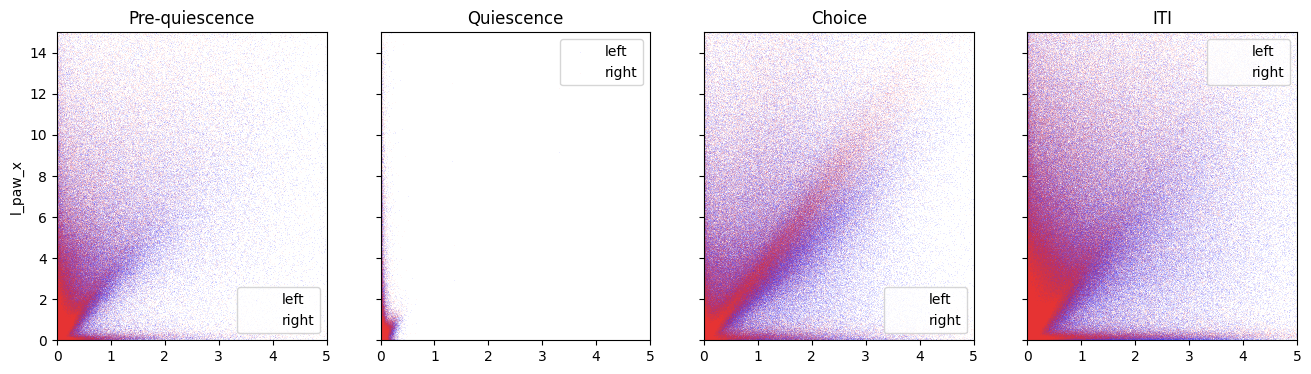

In [25]:

cluster_movements = trial_movement.merge(cluster_df[['mouse_name', 'mouse_cluster']], on='mouse_name')
epochs = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 4))
for i in range(4):

    # use_data = trial_movement.loc[trial_movement['identifiable_states'].isin(syllable[i])]
    use_data = cluster_movements.loc[(cluster_movements['broader_label']==epochs[i])]
    use_data['avg_wheel_vel'] = np.abs(use_data['avg_wheel_vel'])

    # sns.regplot(x=np.array(use_data['avg_wheel_vel']).astype(float), y=use_data['l_paw_x'].astype(float), 
    #             ci=95, marker='o', color='blue', scatter_kws={'s':.1, 'alpha':.05}, ax=axs[i, c], label='left') 
    # sns.regplot(x=np.array(use_data['avg_wheel_vel']).astype(float), y=use_data['r_paw_x'].astype(float), 
    #             ci=95, marker='o', color='pink', scatter_kws={'s':.1, 'alpha':.05}, ax=axs[i, c], label='right') 
    sns.scatterplot(x=np.array(use_data['avg_wheel_vel']).astype(float), y=use_data['l_paw_x'].astype(float), 
                marker='o', color='blue', s=.5, alpha=.1, ax=axs[i], label='left') 
    sns.scatterplot(x=np.array(use_data['avg_wheel_vel']).astype(float), y=use_data['r_paw_x'].astype(float), 
                marker='o', color='red', s=.5, alpha=.05, ax=axs[i], label='right') 
    # axs[i, c].set_ylim([0, 20])
    # axs[i, c].set_xlim([0, 6])
    axs[i].set_title(epochs[i])
    axs[i].set_ylim([0, 15])
    axs[i].set_xlim([0, 5])

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_68844/2029475921.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['avg_wheel_vel'] = np.abs(use_data['avg_wheel_vel'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_68844/2029475921.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['avg_wheel_vel'] = np.abs(use_data['avg_wheel_vel'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_68844/2029475921.py:13: SettingWithCopyWarning: 
A value is trying to b

Text(0, 0.5, 'Paw speed (px/s)')

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


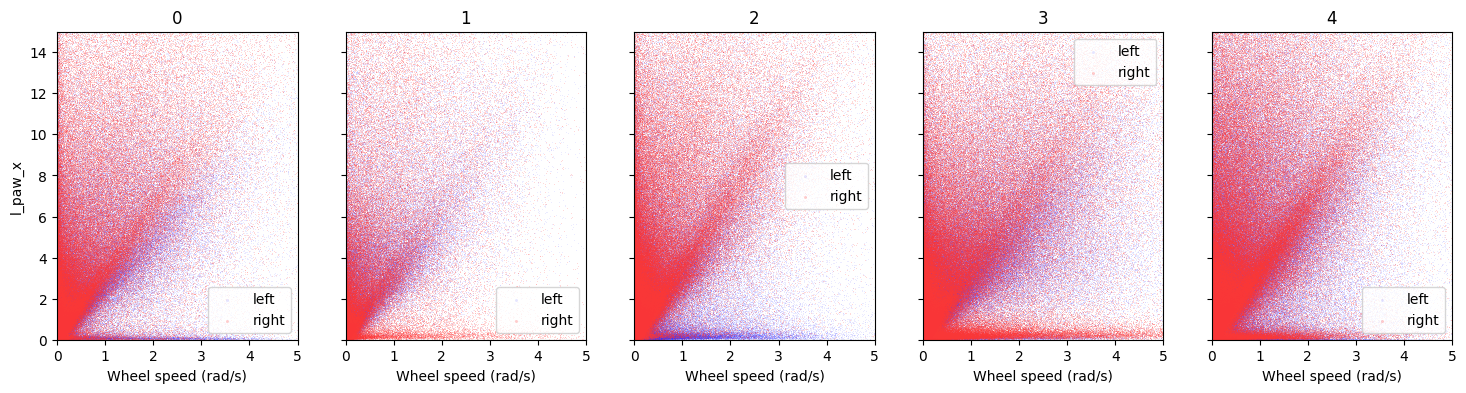

In [48]:

# cluster_movements = trial_movement.merge(cluster_df[['session', 'session_cluster']])
cluster_movements = trial_movement.merge(cluster_df[['mouse_name', 'mouse_cluster']], on='mouse_name')

clusters_unique = np.unique(cluster_movements['mouse_cluster'])
clusters = np.arange(0, len(clusters_unique), 1)
epochs = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

fig, axs = plt.subplots(1, len(clusters_unique), sharex=True, sharey=True, figsize=(18, 4))
for c, cluster in enumerate(clusters):

    # use_data = trial_movement.loc[trial_movement['identifiable_states'].isin(syllable[i])]
    use_data = cluster_movements.loc[(cluster_movements['mouse_cluster']==cluster)]
    use_data['avg_wheel_vel'] = np.abs(use_data['avg_wheel_vel'])

    # sns.regplot(x=np.array(use_data['avg_wheel_vel']).astype(float), y=use_data['l_paw_x'].astype(float), 
    #             ci=95, marker='o', color='blue', scatter_kws={'s':.1, 'alpha':.05}, ax=axs[i, c], label='left') 
    # sns.regplot(x=np.array(use_data['avg_wheel_vel']).astype(float), y=use_data['r_paw_x'].astype(float), 
    #             ci=95, marker='o', color='pink', scatter_kws={'s':.1, 'alpha':.05}, ax=axs[i, c], label='right') 
    sns.scatterplot(x=np.array(use_data['avg_wheel_vel']).astype(float), y=use_data['l_paw_x'].astype(float), 
                marker='o', color='blue', s=.5, alpha=.1, ax=axs[c], label='left') 
    sns.scatterplot(x=np.array(use_data['avg_wheel_vel']).astype(float), y=use_data['r_paw_x'].astype(float), 
                marker='o', color='red', s=.5, alpha=.2, ax=axs[c], label='right') 

    axs[c].legend(markerscale=3)   
    axs[c].set_title(cluster)
    # axs[i, c].set_ylim([0, 20])
    # axs[i, c].set_xlim([0, 6])
    axs[c].set_ylim([0, 15])
    axs[c].set_xlim([0, 5])
    axs[c].set_xlabel('Wheel speed (rad/s)')
axs[c].set_ylabel('Paw speed (px/s)')

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_18347/436458760.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['avg_wheel_vel'] = np.abs(use_data['avg_wheel_vel'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_18347/436458760.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['avg_wheel_vel'] = np.abs(use_data['avg_wheel_vel'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_18347/436458760.py:16: SettingWithCopyWarning: 
A value is trying to be s

Text(0, 0.5, 'Paw speed (px/s)')

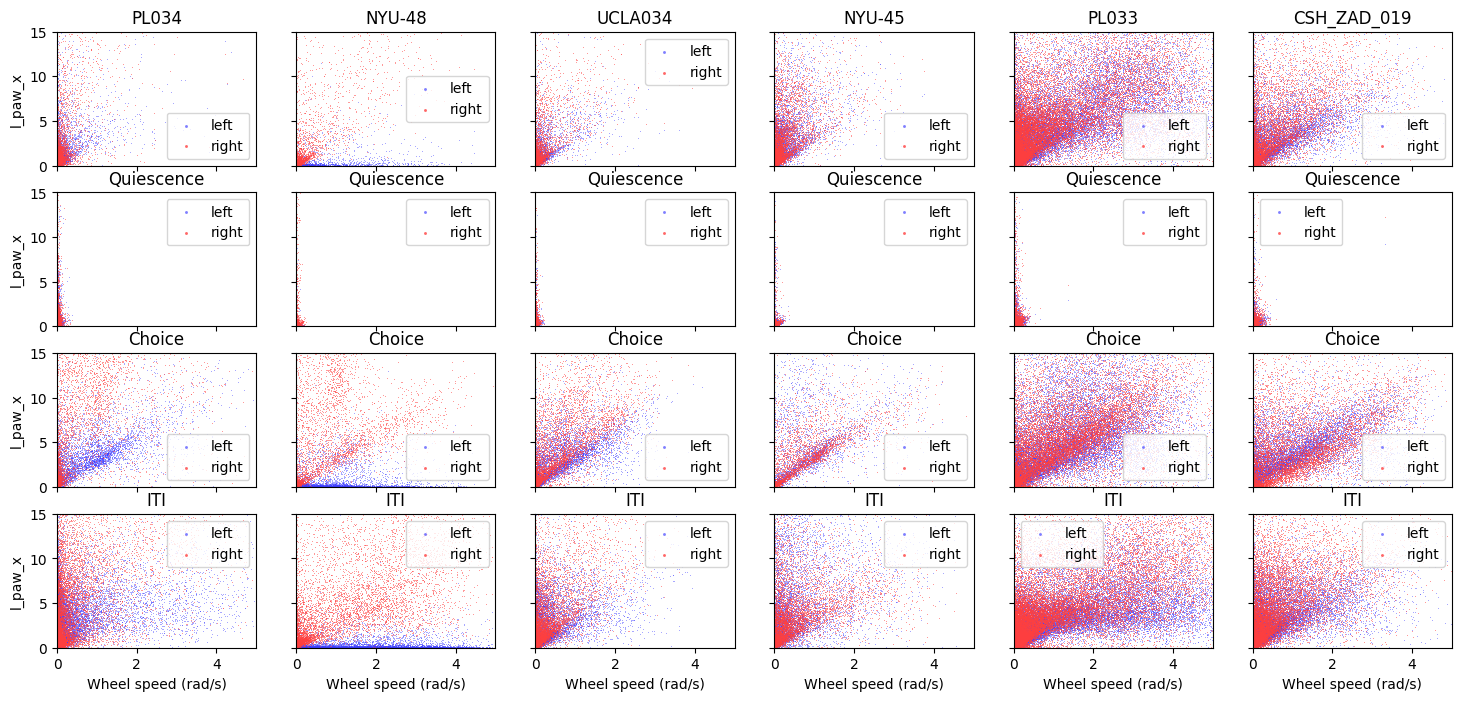

In [81]:
# cluster_movements = trial_movement.merge(cluster_df[['session', 'session_cluster']])
cluster_movements = trial_movement.merge(cluster_df[['mouse_name', 'mouse_cluster']], on='mouse_name')

clusters_unique = np.unique(cluster_movements['mouse_cluster'])
clusters = np.arange(0, len(clusters_unique), 1)
epochs = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

fig, axs = plt.subplots(4, 6, sharex=True, sharey=True, figsize=(18, 8))
# for c, cluster in enumerate(clusters):
for c, mat in enumerate(['PL034', 'NYU-48', 'UCLA034', 'NYU-45', 'PL033', 'CSH_ZAD_019']):
# for c, mat in enumerate(['PL034', 'UCLA034', 'PL033']):
# for c, mat in enumerate(['PL034', 'NYU-45','NYU-47']):
    for e, epoch in enumerate(epochs):
        use_data = cluster_movements.loc[(cluster_movements['mouse_name']==mat) &
                                         (cluster_movements['broader_label']==epoch)]
        use_data['avg_wheel_vel'] = np.abs(use_data['avg_wheel_vel'])
        sns.scatterplot(x=np.array(use_data['avg_wheel_vel']).astype(float), y=use_data['l_paw_x'].astype(float), 
                    marker='o', color='blue', s=.5, alpha=.5, ax=axs[e, c], label='left') 
        sns.scatterplot(x=np.array(use_data['avg_wheel_vel']).astype(float), y=use_data['r_paw_x'].astype(float), 
                    marker='o', color='red', s=.5, alpha=.6, ax=axs[e, c], label='right') 

        axs[e, c].legend(markerscale=3)   
        axs[e, c].set_title(epoch)
        axs[0, c].set_title(mat)
        # axs[i, c].set_ylim([0, 20])
        # axs[i, c].set_xlim([0, 6])
        axs[e, c].set_ylim([0, 15])
        axs[e, c].set_xlim([0, 5])
        axs[e, c].set_xlabel('Wheel speed (rad/s)')
axs[e, c].set_ylabel('Paw speed (px/s)')

Text(0, 0.5, 'Paw speed (px/s)')

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


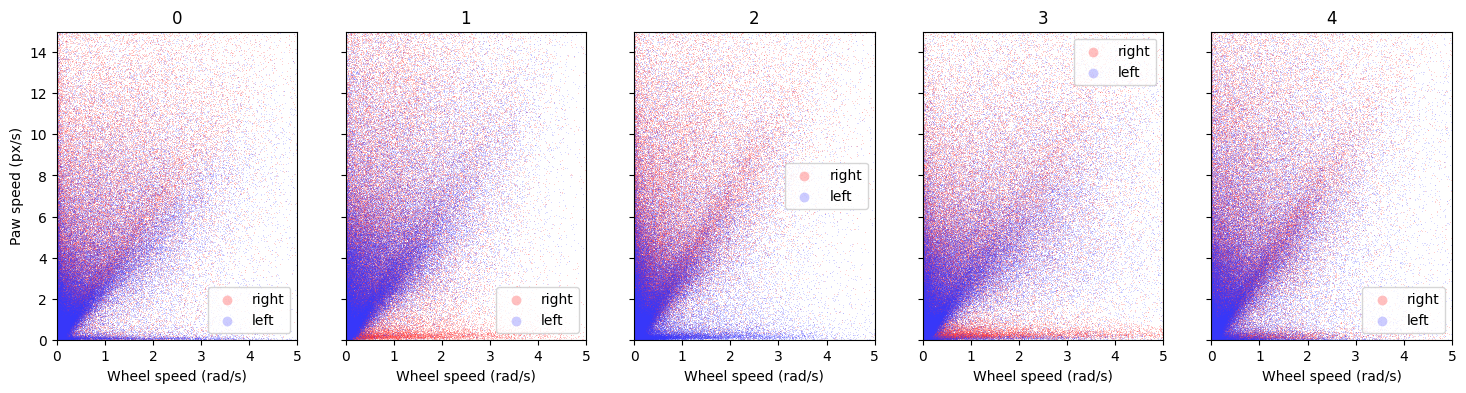

In [113]:

# cluster_movements = trial_movement.merge(cluster_df[['session', 'session_cluster']])
cluster_movements = trial_movement.merge(cluster_df[['mouse_name', 'mouse_cluster']], on='mouse_name').dropna()
# Find minimum number of samples per label
min_freq = np.min(cluster_movements['mouse_cluster'].value_counts())

clusters_unique = np.unique(cluster_movements['mouse_cluster'])
clusters = np.arange(0, len(clusters_unique), 1)
epochs = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

# from matplotlib.lines import Line2D
# legend_handles = Line2D([0], [0],marker='o', alpha=1,  markersize=10)

fig, axs = plt.subplots(1, len(clusters_unique), sharex=True, sharey=True, figsize=(18, 4))
for c, cluster in enumerate(clusters):

    use_data = cluster_movements.loc[(cluster_movements['mouse_cluster']==cluster)]
    use_data = use_data.loc[np.random.choice(np.array(use_data.index), min_freq, replace=False)]
    use_data['avg_wheel_vel'] = np.abs(use_data['avg_wheel_vel'])
    sns.scatterplot(x=np.array(use_data['avg_wheel_vel']).astype(float), y=use_data['r_paw_x'].astype(float), 
                marker='o', color='red', s=.5, alpha=.25, ax=axs[c], label='right') 
    sns.scatterplot(x=np.array(use_data['avg_wheel_vel']).astype(float), y=use_data['l_paw_x'].astype(float), 
                marker='o', color='blue', s=.5, alpha=.20, ax=axs[c], label='left') 


    axs[c].set_title(cluster)
    # axs[i, c].set_ylim([0, 20])
    # axs[i, c].set_xlim([0, 6])
    axs[c].set_ylim([0, 15])
    axs[c].set_xlim([0, 5])
    axs[c].set_xlabel('Wheel speed (rad/s)')
    axs[c].legend(markerscale=10) 
axs[0].set_ylabel('Paw speed (px/s)')

/tmp/ipykernel_4777/3269416677.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['avg_wheel_vel'] = np.abs(use_data['avg_wheel_vel'])
/tmp/ipykernel_4777/3269416677.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['avg_wheel_vel'] = np.abs(use_data['avg_wheel_vel'])
/tmp/ipykernel_4777/3269416677.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

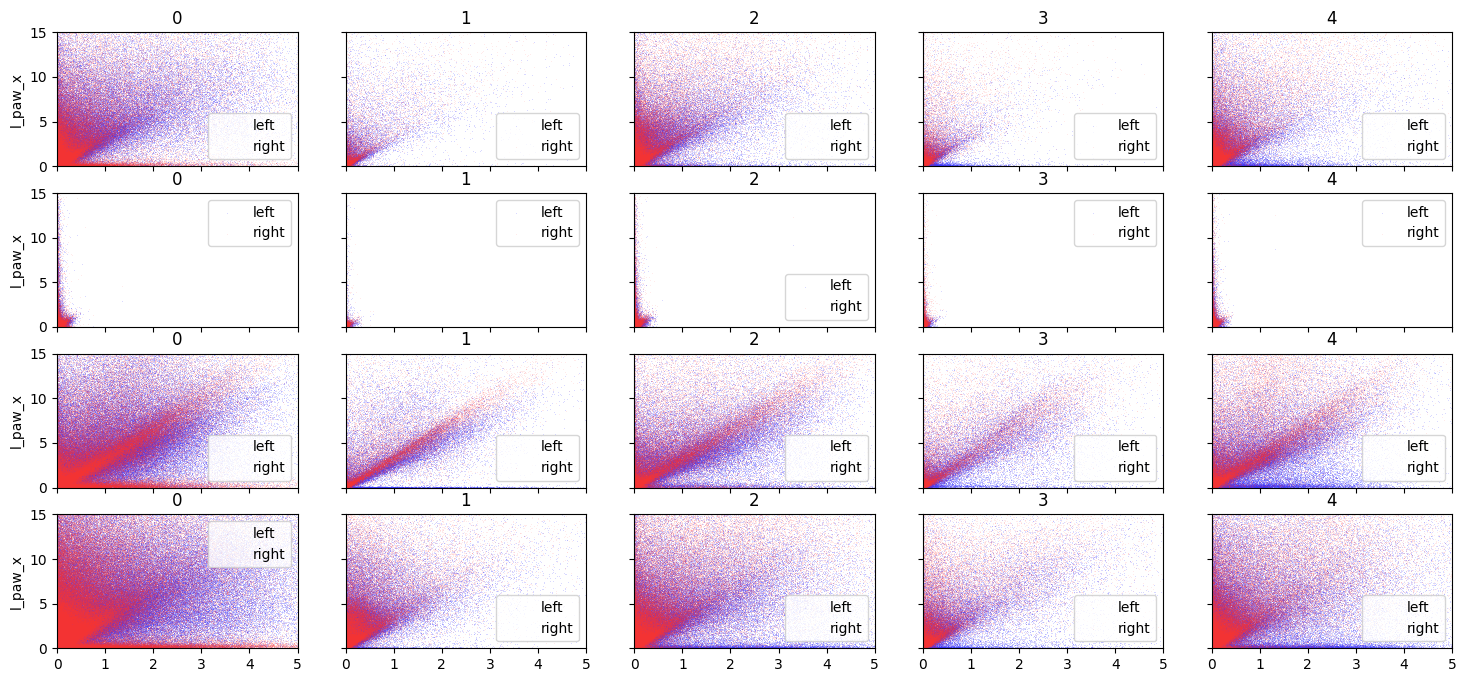

In [ ]:
cluster_movements = trial_movement.merge(cluster_df[['mouse_name', 'mouse_cluster']], on='mouse_name')

clusters_unique = np.unique(cluster_movements['mouse_cluster'])
clusters = np.arange(0, len(clusters_unique), 1)
epochs = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']
# min_freq = np.min(cluster_movements['mouse_cluster'].value_counts())

fig, axs = plt.subplots(4, len(clusters_unique), sharex=True, sharey=True, figsize=(18, 8))
for c, cluster in enumerate(clusters):
    for i in range(4):

        # use_data = trial_movement.loc[trial_movement['identifiable_states'].isin(syllable[i])]
        use_data = cluster_movements.loc[(cluster_movements['mouse_cluster']==cluster) & 
                                         (cluster_movements['broader_label']==epochs[i])]
        # use_data = use_data.loc[np.random.choice(np.array(use_data.index), min_freq, replace=False)]

        use_data['avg_wheel_vel'] = np.abs(use_data['avg_wheel_vel'])

        # sns.regplot(x=np.array(use_data['avg_wheel_vel']).astype(float), y=use_data['l_paw_x'].astype(float), 
        #             ci=95, marker='o', color='blue', scatter_kws={'s':.1, 'alpha':.05}, ax=axs[i, c], label='left') 
        # sns.regplot(x=np.array(use_data['avg_wheel_vel']).astype(float), y=use_data['r_paw_x'].astype(float), 
        #             ci=95, marker='o', color='pink', scatter_kws={'s':.1, 'alpha':.05}, ax=axs[i, c], label='right') 
        sns.scatterplot(x=np.array(use_data['avg_wheel_vel']).astype(float), y=use_data['l_paw_x'].astype(float), 
                    marker='o', color='blue', s=.5, alpha=.2, ax=axs[i, c], label='left') 
        sns.scatterplot(x=np.array(use_data['avg_wheel_vel']).astype(float), y=use_data['r_paw_x'].astype(float), 
                    marker='o', color='red', s=.5, alpha=.1, ax=axs[i, c], label='right') 

        axs[i, c].set_ylim([0, 15])
        axs[i, c].set_xlim([0, 5])
        axs[0, c].set_title(cluster)


# Plot statistics per fingerprint

In [12]:
trials_df = complete_df.drop(columns=['broader_label', 'binned_sequence']).drop_duplicates()
# trials_df = trials_df.merge(cluster_df[['mouse_name', 'session', 'session_cluster']], on=['mouse_name', 'session'])

In [13]:
# Get timing info
data_path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
states_file = pd.read_parquet(data_path+'states_trial_type_09-29-2025')
vars = ['trial_id', 'mouse_name']
elongation = pd.DataFrame(states_file.groupby(vars)['elongation'].mean()).reset_index()
elongation['trial_id'] = elongation['trial_id'].astype(str)
response = pd.DataFrame(states_file.groupby(vars)['response'].mean()).reset_index()
response['trial_id'] = response['trial_id'].astype(str)
reaction = pd.DataFrame(states_file.groupby(vars)['reaction'].mean()).reset_index()
reaction['trial_id'] = reaction['trial_id'].astype(str)

del states_file

# Merge
trials_df = trials_df.merge(elongation, on=['trial_id', 'mouse_name'])
trials_df = trials_df.merge(response, on=['trial_id', 'mouse_name'])
trials_df = trials_df.merge(reaction, on=['trial_id', 'mouse_name'])

In [15]:
data_path = prefix + 'representation_learning_variability/DATA/'
# data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/'
learning_df = pd.read_csv(data_path+'learning_private_one.csv')
learning_times = learning_df[['subject_nickname', 'training_time']].drop_duplicates()
learning_times = learning_times.rename(columns={"subject_nickname": "mouse_name"}).reset_index()

data_path =  prefix + 'representation_learning_variability/DATA/'
learning_df = pd.read_parquet(data_path+'training_time_03-21-2025', engine='pyarrow')
learning_times_new = learning_df.rename(columns={"subject_nickname": "mouse_name"}).reset_index()

# new_df = design_df.droplevel(1, axis=1)[['mouse_name', 'session']]
# df = new_df.merge(learning_times, on='mouse_name')
a = learning_times.merge(learning_times_new, on='mouse_name', how='outer')
b = a.loc[a['training_time_x'].isna()]
b = b.rename(columns={"training_time_y": "training_time"}).reset_index()

full_learning = pd.concat([learning_times[['mouse_name', 'training_time']], b[['mouse_name', 'training_time']]]).reset_index()

/tmp/ipykernel_9081/1096352341.py:3: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  learning_df = pd.read_csv(data_path+'learning_private_one.csv')


In [16]:
trials_df = trials_df.merge(full_learning[['mouse_name', 'training_time']], on='mouse_name')

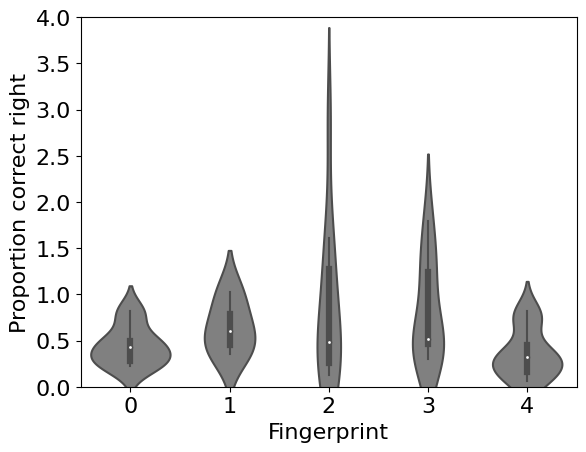

P-value for KW: 0.109
     0    1         2         3         4
0  1.0  1.0  1.000000  1.000000  1.000000
1  1.0  1.0  1.000000  1.000000  1.000000
2  1.0  1.0  1.000000  1.000000  0.614117
3  1.0  1.0  1.000000  1.000000  0.157632
4  1.0  1.0  0.614117  0.157632  1.000000


In [27]:
# --Machine learning and statistics
from scipy.stats import ttest_ind
from sklearn.metrics import f1_score
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

var_1 = 'training_time ~ mouse_cluster'
var = 'training_time'
var = 'elongation'
var_1 = 'elongation ~ mouse_cluster'

data = pd.DataFrame(trials_df.groupby(['mouse_name', 'session', 'mouse_cluster'])[var].mean()).reset_index().dropna()
data = pd.DataFrame(trials_df.groupby(['mouse_name', 'mouse_cluster'])[var].median()).reset_index().dropna()
data[var] = data[var].astype(float)

model = ols(var_1, data=data).fit()

plt.rcParams.update({'font.size': 16})
sns.violinplot(x='mouse_cluster', y=var, data=data, color='grey') # , palette=sns.light_palette("seagreen", 3, as_cmap=False))
# sns.barplot(x='session_cluster', y=var, data=data, palette=sns.light_palette("seagreen", 3, as_cmap=False))
# sns.scatterplot(x='part_cluster', y=var, data=data, color='black')
# plt.xticks([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5])
plt.ylim([0, 80])
plt.ylim([0, 4])
# plt.ylim([0.5, 1])
# plt.ylim([0, 1])
plt.xlabel('Fingerprint')
plt.ylabel('Proportion correct right')
# plt.ylabel('Trial elongation (s)')
# plt.ylabel('Reaction time (s)')
plt.show()
    
#keep_clusters = [ 0,  2,  3,  4,  5,  6,  8, 10]
group_1 = data.loc[data['mouse_cluster']==0, var]
group_2 = data.loc[data['mouse_cluster']==1, var]
group_3 = data.loc[data['mouse_cluster']==2, var]
group_4 = data.loc[data['mouse_cluster']==3, var]
group_5 = data.loc[data['mouse_cluster']==4, var]
# group_6 = data.loc[data['mouse_cluster']==5, var]

# stat, p_value = stats.kruskal(group_1, group_2, group_3, group_4, group_5, group_6)
stat, p_value = stats.kruskal(group_1, group_2, group_3, group_4, group_5)
# stat, p_value = stats.kruskal(group_1, group_2, group_3)


print(f"P-value for KW: {p_value:.3f}")

posthoc = sp.posthoc_dunn(data.dropna(), val_col=var, group_col='mouse_cluster', p_adjust='bonferroni')
print(posthoc)